### Image processing

In [2]:
import pandas as pd
df1 = pd.read_csv("Data/X_train_update.csv", index_col = 0)
df1.head()

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [3]:
df2 = pd.read_csv("Data/Y_train_CVw08PX.csv", index_col = 0)
df2.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [4]:
codes = sorted(list(set(df2["prdtypecode"].values)))

In [ ]:
len(codes)

In [5]:
new_codes = [*range(27)]

In [5]:
print(len(new_codes))

27


In [6]:
df = pd.concat([df1["productid"], df1["imageid"], df2["prdtypecode"]], axis = 1)
df.head()

,productid,imageid,prdtypecode
0,3804725264,1263597046,10
1,436067568,1008141237,2280
2,201115110,938777978,50
3,50418756,457047496,1280
4,278535884,1077757786,2705


In [7]:
df["img"] = df.astype("str").apply(lambda row: "image_" + row["imageid"]+ "_product_" + row["productid"] + ".jpg", axis=1)
df.head()

,productid,imageid,prdtypecode,img
0,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg
1,436067568,1008141237,2280,image_1008141237_product_436067568.jpg
2,201115110,938777978,50,image_938777978_product_201115110.jpg
3,50418756,457047496,1280,image_457047496_product_50418756.jpg
4,278535884,1077757786,2705,image_1077757786_product_278535884.jpg


In [8]:
df["codes"] = df["prdtypecode"].replace(to_replace = codes, value = new_codes)

In [ ]:
#df["codes"] = df["codes"]/100

In [9]:
df.head()

,productid,imageid,prdtypecode,img,codes
0,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg,0
1,436067568,1008141237,2280,image_1008141237_product_436067568.jpg,18
2,201115110,938777978,50,image_938777978_product_201115110.jpg,2
3,50418756,457047496,1280,image_457047496_product_50418756.jpg,7
4,278535884,1077757786,2705,image_1077757786_product_278535884.jpg,25


In [10]:
import numpy as np

In [11]:
from tensorflow import keras

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age
from keras.utils import to_categorical



In [14]:
from PIL import Image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

image_path = 'image_train/'

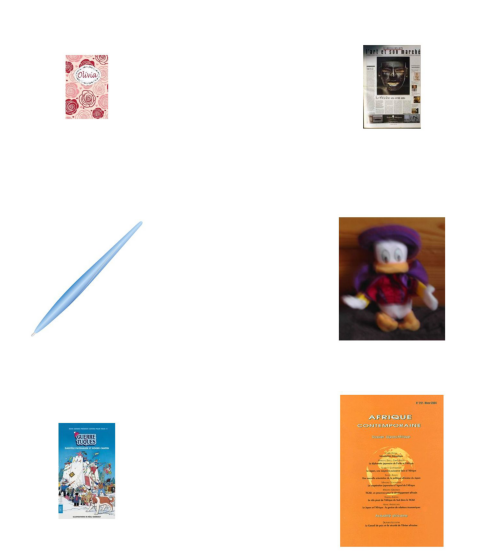

In [15]:
number_of_images = 6 #Définir le nombre x d'images à afficher 
plt.figure(figsize=(10,10))
images = os.listdir(image_path)[:number_of_images] # Selectionner aléatoirement x images
for i in range(number_of_images):
    file = mpimg.imread(image_path + df["img"][i])
    plt.subplot(3, 2, i+1)
    plt.axis('off')
    plt.imshow(file)



In [ ]:
X = []
Y = []
width = 50
height = 50

for ind in range(len(df["img"])):
    file_path = image_path + df["img"][ind] + ".jpg"
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = image.resize((width, height))
    X.append(np.array(image))
    #Y.append(df["prdtypecode"][ind])
    Y.append(df["codes"][ind])

In [ ]:
print(Y[0])

In [ ]:
X = np.array(X)
X = X.astype("float32")
X /= 255.0
print("Min: %.3f, Max: %.3f" % (X.min(), X.max()))
Y = np.array(Y)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1))

In [ ]:
print(Y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True, stratify = Y)

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
test_datagen = ImageDataGenerator()

In [ ]:
train_dataset = train_datagen.flow(X_train, y_train, batch_size = 128)
test_dataset = test_datagen.flow(X_test, y_test, batch_size = 128)

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (2, 2), activation = 'relu', padding = "valid", input_shape = (50, 50, 3)))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32, (2, 2), activation = 'relu'))
model1.add(MaxPooling2D(2,2))
#model1.add(Dropout(rate = 0.2))
model1.add(Flatten())
model1.add(Dense(128, activation="relu"))
model1.add(Dense(27, activation="softmax"))

In [ ]:
model1.summary()

In [ ]:
model1.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])
#model.compile(optimizer="adam",loss="mse",metrics=['mean_absolute_error'])

In [ ]:
batch_size = 128
epochs = 15 
model1_history = model1.fit_generator(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            verbose=True)

In [ ]:
train_acc = model1_history.history['accuracy']
val_acc = model1_history.history['val_accuracy']

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(np.arange(1,16,1),
        train_acc,
        label = "Training Accuracy",
        color = "blue")
plt.plot(np.arange(1, 16, 1),
        val_acc,
        label = "Validation Accuracy",
        color = "red")

plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_pred = model1.predict(X_test)

In [ ]:
y_pred_class = np.argmax(test_pred, axis = 1)

In [ ]:

print(metrics.classification_report(y_test, y_pred_class))

In [ ]:
y_test_1 = y_test.reshape(-1)

In [ ]:
pd.crosstab(y_test_1, y_pred_class, rownames = ["Current class"], colnames = ["Predicted class"])

## Bounding box

In [16]:
import cv2 

In [17]:
img_0 = cv2.imread(image_path + df["img"][21624])

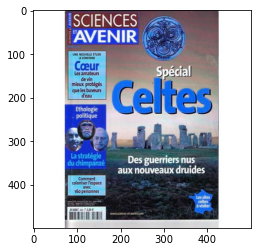

In [206]:
plt.imshow(img_0)

In [20]:
## Run this cell to store all images with bounding boxes locally in the folder bb

#for el in df["img"][:10]:
 #   path = "image_train/"
  #  contouring(el, path)

In [18]:
# Function for contouring the largest container that includes all boxes and stores the new images within the /bb directory

def contouring(imag, img_path):
    image_path = img_path
    img_0 = cv2.imread(image_path + imag)
    gray_image = cv2.cvtColor(img_0, cv2.COLOR_BGR2GRAY)
    thresh_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    size = 500
    r, l, t, b = 0, 0, 0, 0
    right, left, top, bottom = [], [], [], []
    if len(contours) < 3:
        for i in contours:
            x,y,w,h = cv2.boundingRect(i)
        cv2.rectangle(img_0, (x, y), (x + w, y + h), (255,0,0), 4)

    else:
        for i in contours:
            x,y,w,h = cv2.boundingRect(i)
            l = x
            r = l + w
            t = y
            b = t + h
            right.append(r)
            top.append(t)
            left.append(l)
            bottom.append(b)
            
        x = min(left)
        y = min(top)
        w = (max(right)-min(left))
        h = (max(bottom)-min(top))
        
    #print("x", x, "y", y, "w_f", w, "h_f", h_f)
    # Draw the contour
    cv2.rectangle(img_0, (int(x), int(y)), (int(x + w), int(y + h)), (255,0,0), 4)
    #return cv2.imwrite(image_path + 'bb/' + imag, img_0)
    return plt.imshow(img_0)

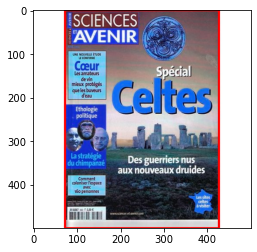

In [19]:
contouring(df["img"][21624], "image_train/")

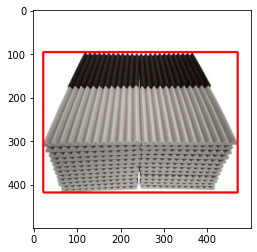

In [23]:
contouring(df["img"][1303], "image_train/")

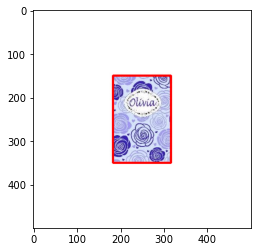

In [24]:
contouring(df["img"][0], "image_train/")